## Appendix E: Comparison to jwst observations and using [Sanders+2024](https://ui.adsabs.harvard.edu/abs/2024ApJ...962...24S/abstract) calibrations

In [ ]:
from functools import partial
import numpy as np
import h5py
from unyt import Msun, Myr, Angstrom, erg, s, Hz, cm
from astropy.cosmology import LambdaCDM
import pandas as pd
from schwimmbad import MultiPool
from uncertainties import unumpy
from scipy.stats import gaussian_kde

from synthesizer.grid import Grid
from synthesizer.particle import Galaxy
from synthesizer.instruments.filters import FilterCollection

from synthesizer.emission_models import PacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emissions.utils import (
    Ha,
    Hb, 
    O2b,
    O2r,
    O3r,
    O3b,
    O3,
)
from synthesizer.conversions import lnu_to_absolute_mag

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cmasher as cmr

from utilities import (
    binned_weighted_quantile, 
    compute_metallicity_dust_correction,
    compute_metallicity_nodust_correction
)

from obs_data_plots import (
    plot_met_data,
    plot_rebels_data
)

cosmo = LambdaCDM(Om0=0.307, Ode0=0.693, H0=67.77, Ob0=0.04825)
plt.style.use('styles/style.mplstyle')

# Set the random seed for reproducibility
np.random.seed(680010)

In [ ]:
def get_data(ii, tag, OIIIlimit=1e-17*erg/s/cm**2, cosmo=cosmo):
    """Helper function to retreive FLARES data relevant for this notebook.
    
    Args:
        ii (int): The index of the simulation to retreive data for.
        tag (str): The redshift tag to retreive data for, e.g. 'z5p0'.
        OIIIlimit (float): The flux limit to apply to the [OIII]5007 line, in units of erg/s/cm^2.
        cosmo (astropy.cosmology): The cosmology to use for distance calculations.
        
    Returns:
        tuple: A tuple containing the following arrays:
            - Mstar: The stellar mass of the galaxies, in units of Msun.    
            - MFUVatt: The absolute magnitude in the FUV band, including dust attenuation.
            - Halpha: The luminosity of the Halpha line, including dust attenuation, in units of erg/s.
            - OIII5007: The luminosity of the [OIII]5007 line, including dust attenuation, in units of erg/s.
            - OIII4959: The luminosity of the [OIII]4959 line, including dust attenuation, in units of erg/s.
            - OII3727: The luminosity of the [OII]3727 line, including dust attenuation, in units of erg/s.
            - NeIII3869: The luminosity of the [NeIII]3869 line, including dust attenuation, in units of erg/s.
            - OIII5007int: The luminosity of the [OIII]5007 line, without dust attenuation, in units of erg/s.
            - OIII4959int: The luminosity of the [OIII]4959 line, without dust attenuation, in units of erg/s.
            - OII3727int: The luminosity of the [OII]3727 line, without dust attenuation, in units of erg/s.
            - NeIII3869int: The luminosity of the [NeIII]3869 line, without dust attenuation, in units of erg/s.
            - Hbeta: The luminosity of the Hbeta line, including dust attenuation, in units of erg/s.
            - Halphaint: The luminosity of the Halpha line, without dust attenuation, in units of erg/s.
            - Hbetaint: The luminosity of the Hbeta line, without dust attenuation, in units of erg/s.
            - MassweightedZ: The mass-weighted metallicity of the galaxy, in units of Zsun.
            - Av: The V-band attenuation of the galaxy, in magnitudes.
    """

    z = float(tag[5:].replace('p','.'))
    
    num = str(ii)

    if len(num) == 1:
        num =  '0'+num

    sim = "./data/flares_shared_data.hdf5"
    num = num+'/'

    with h5py.File(sim, 'r') as hf:
        Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
        MassweightedZ = np.array(hf[num+tag+'/Galaxy/Metallicity'].get('MassWeightedYoungStellarZ'), dtype = np.float32)

        MFUVatt = lnu_to_absolute_mag(np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('FUV'), dtype = np.float32) * erg / s / Hz)

        Av = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('V'), dtype = np.float32) / np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('V'), dtype = np.float32)
        Av = -2.5 * np.log10(Av)

        Halpha = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbeta = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI4861'].get('Luminosity'), dtype = np.float64)
        HbetaEW = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI4861'].get('EW'), dtype = np.float64)
        Halphaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbetaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI4861'].get('Luminosity'), dtype = np.float64)

        OIII5007 = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/OIII5007'].get('Luminosity'), dtype = np.float64)
        OIII4959 = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/OIII4959'].get('Luminosity'), dtype = np.float64)
        OII3727 = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/OII3726'].get('Luminosity'), dtype = np.float64) + np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/OII3729'].get('Luminosity'), dtype = np.float64)
        NeIII3869 = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/NeIII3869'].get('Luminosity'), dtype = np.float64)
        # + np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI3889'].get('Luminosity'), dtype = np.float64) + np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HeI3889'].get('Luminosity'), dtype = np.float64)

        OIII5007int = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/OIII5007'].get('Luminosity'), dtype = np.float64)
        OIII4959int = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/OIII4959'].get('Luminosity'), dtype = np.float64)
        OII3727int = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/OII3726'].get('Luminosity'), dtype = np.float64) + np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/OII3729'].get('Luminosity'), dtype = np.float64)
        NeIII3869int = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/NeIII3869'].get('Luminosity'), dtype = np.float64)

    lum_dist = cosmo.luminosity_distance(z).to("cm").value * cm
    OIII5007flux = OIII5007 * (erg/s) * (1+z) / (4 * np.pi * lum_dist**2)

    ok = (Halphaint>0) * (Mstar>1e8) * (OIII5007flux>=OIIIlimit)

    return Mstar[ok], MFUVatt[ok], Halpha[ok], OIII5007[ok], OIII4959[ok], OII3727[ok], NeIII3869[ok], OIII5007int[ok], OIII4959int[ok], OII3727int[ok], NeIII3869int[ok], Hbeta[ok], Halphaint[ok], Hbetaint[ok], MassweightedZ[ok], Av[ok], HbetaEW[ok]

def plot_contour(x, y, ax, cmap, label, zorder, alpha=0.5):
    
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)

    # Evaluate KDE on a grid
    xgrid = np.linspace(min(x), max(x), 100, endpoint=True)
    ygrid = np.linspace(min(y), max(y), 100, endpoint=True)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    Z = kde(np.vstack([Xgrid.ravel(), Ygrid.ravel()])).reshape(Xgrid.shape)
    
    z = (Z-Z.min())/(Z.max() - Z.min())
    
    levels = [0, 0.1, 0.25, 0.5, 0.68, 0.95, 0.975, 0.997, 1]
       
    cs = ax.contour(Xgrid, Ygrid, z, levels=levels, cmap=cmap, label=label, zorder=zorder, alpha=alpha, origin='lower')
         
    return ax

def plot_hexbin(x, y, ax, cmap, label, gridsize, zorder):
    
    ax.hexbin(x, y, gridsize=gridsize, cmap=cmap, label=label, zorder=zorder, mincnt=1, bins='log')
    
    return ax    

In [3]:
# Define the synthesizer grid
grid_name = "bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps"
grid_dir = "./data/"
grid = Grid(grid_name, grid_dir=grid_dir)

Zsun = 0.014

# Define some of the required lines
req_lines = {'H 1 6562.80A': 'Halpha',
             'H 1 4861.32A': 'Hbeta',
             'O 2 3726.03A,O 2 3728.81A': '[OII]3727,29',
             'O 3 4958.91A': '[OIII]4959',
             'O 3 5006.84A': '[OIII]5007',
             'Ne 3 3868.76A': 'NeIII3869'
}

# Define some top hat filters for the UV
tophats = {
    "UV1500": {"lam_eff": 1500*Angstrom, "lam_fwhm": 300*Angstrom},
    "UV2800": {"lam_eff": 2800*Angstrom, "lam_fwhm": 300*Angstrom},
}

filters = FilterCollection(
    filter_codes=[f'Generic/Johnson.V'],
    tophat_dict=tophats,
    new_lam=grid.lam
)

li = [
       Ha,
       Hb, 
       O2b,
       O2r,
       O3r,
       O3b,
       O3,
       'Ne 3 3868.76A'
   ]

### Create toy model galaxies 
(Same across all notebooks)

In [ ]:
redshift = 6.
# Number of star particles
n = 100
ages = 10**np.random.uniform(0, np.log10(50), size=n) * Myr
Z = 10**np.random.uniform(-3.5, -2., size=n)
mass = 1e6*np.random.uniform(2, 5, n) * Msun 

# Dust distributions
max_tau = 7
mu, sigma = 0.3, 0.4
nsigma = np.arange(0,max_tau,2)
num_gals = len(nsigma)
colors = cmr.take_cmap_colors('cmr.gem_r', num_gals, return_fmt='rgb')

# Property holders
logOH = np.zeros(4)
lum_int = np.zeros(4, dtype=object)
line_int = np.zeros(4, dtype=object)
sed_int = np.zeros(4, dtype=object)

line_emergent = np.zeros((4, num_gals), dtype=object)
sed_emergent = np.zeros((4, num_gals), dtype=object)
lum_att = np.zeros((4, num_gals))
Av = np.zeros((4, num_gals))
att_curve = np.zeros((4, num_gals, len(grid.lam)))

# Vary everything
gal = Galaxy(redshift=redshift)
gal.load_stars(
    ages=ages,
    metallicities=Z,
    initial_masses=mass 
)
ok = gal.stars.ages<=10*Myr
Zmean = np.sum(gal.stars.initial_masses[ok] * gal.stars.metallicities[ok]) / np.sum(gal.stars.initial_masses[ok])
Agemean = np.sum(gal.stars.initial_masses[ok] * gal.stars.ages[ok]) / np.sum(gal.stars.initial_masses[ok])

print (Zmean, Agemean)

# Keep everything fixed
gal_const = Galaxy(redshift=redshift)
gal_const.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary age
gal_vary_age = Galaxy(redshift=redshift)
gal_vary_age.load_stars(
    ages=ages,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary metallicity
gal_vary_Z = Galaxy(redshift=redshift)
gal_vary_Z.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=Z,
    initial_masses=mass 
)

all_gals = [gal_const, gal_vary_age, gal_vary_Z, gal]

tau_v = np.zeros((num_gals, n))
for ii in range(num_gals):
    tmp  = mu + np.random.normal(0, sigma*nsigma[ii], n)
    tmp[tmp<0] = 0.01
    tau_v[ii] = tmp

for jj, kk in enumerate(all_gals):
    # print ("Galaxy number: ", jj)
    ok = kk.stars.ages<=10*Myr
    Zmean = np.sum(kk.stars.initial_masses[ok] * kk.stars.metallicities[ok]) / np.sum(kk.stars.initial_masses[ok])    
    logOH[jj] = 8.69 + np.log10(Zmean/Zsun)

    for ii in range(num_gals):
        
        emodel = PacmanEmission(
            grid=grid,
            tau_v=tau_v[ii],
            dust_curve=PowerLaw(),
            per_particle=True
        )    
    
        kk.stars.get_spectra(emission_model=emodel)    
        kk.stars.get_lines(li,
            emodel
        )        
        
        line_emergent[jj][ii] = kk.stars.lines['emergent']
        kk.stars.spectra['emergent'].get_fnu(cosmo=cosmo, z=redshift)   
        tmp = kk.stars.spectra['emergent'].get_photo_lnu(filters, verbose=False)
        lum_att[jj][ii] = tmp['Generic/Johnson.V']
        
        sed_emergent[jj][ii] = kk.stars.spectra['emergent']
        att_curve[jj][ii] = -2.5 * np.log10(kk.stars.spectra['emergent'].luminosity/kk.stars.spectra['intrinsic'].luminosity)

    line_int[jj] = kk.stars.lines['intrinsic']    
    lum_int[jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['Generic/Johnson.V']    
    sed_int[jj] = kk.stars.spectra['intrinsic']

    Av[jj] = -2.5 * np.log10(lum_att[jj]/lum_int[jj])
    
# print (Av)
# print (logOH)
# print (np.log10(np.sum(mass)))

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/281244027.py:30: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal.load_stars(
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/281244027.py:43: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal_const.load_stars(
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/281244027.py:51: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal_vary_age.load_stars(
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/281244027.py:59: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal_vary_Z.load_stars(


0.0028716346580942563 dimensionless 3858417.0953785474 yr
Galaxy number:  0


/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


Galaxy number:  1
Galaxy number:  2
Galaxy number:  3
[[0.34113585 0.35105709 0.48577994 0.61489232]
 [0.34103955 0.29787418 0.4914372  0.54169829]
 [0.33742019 0.3558601  0.4666337  0.61345284]
 [0.33882901 0.29868182 0.47472267 0.53628379]]
[8.00200115 8.00200115 7.99470779 8.00200115]
8.547170992041227


# Line ratios

<!-- $S2 = [SII]\lambda 6716,31 / H_{\alpha}$ -->

$R3 = [OIII]\lambda 5007/ H_{\beta}$

$R2 = [OII]\lambda 3727,29/H_{\beta}$

$R23 = \dfrac{[OIII]\lambda 4959,5007 + [OII]\lambda 3727,29}{H_{\beta}}$

$O32 = [OIII]\lambda5007/[OII]\lambda3727,29$

$Ne3O2 = [NeIII]\lambda3869/[OII]\lambda 3727,29$

#### Plot R23 vs O32 and R3 vs Ne3O2 for the toy model galaxies

Figure 15 in paper

<>:140: SyntaxWarning: invalid escape sequence '\m'
<>:140: SyntaxWarning: invalid escape sequence '\m'
<>:140: SyntaxWarning: invalid escape sequence '\m'
<>:140: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/2694430831.py:140: SyntaxWarning: invalid escape sequence '\m'
  twinyaxs[1].legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=True, fontsize=12, loc="lower right")
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/2694430831.py:140: SyntaxWarning: invalid escape sequence '\m'
  twinyaxs[1].legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=True, fontsize=12, loc="lower right")


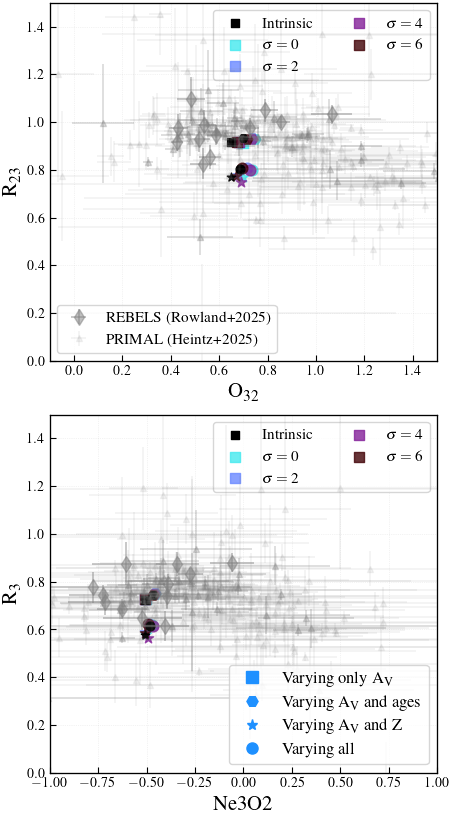

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(5, 10), sharex=False, sharey=False, facecolor='w', edgecolor='k')
axs = axs.ravel()
twinxaxs = [ax.twinx() for ax in axs]
twinyaxs = [ax.twiny() for ax in axs]

line_gals_int, line_gals_att = {}, {}

markers = ['s', 'H', '*', 'o']
custom = [Line2D([], [], marker=ii, markersize=8, color='dodgerblue', linestyle='None') for ii in markers]

for jj, kk in enumerate(all_gals):
    
    tmp = {value: line_int[jj][key].luminosity.sum() for key, value in req_lines.items()}
    tmp['R23'] = (tmp['[OIII]4959']+tmp['[OIII]5007']+tmp['[OII]3727,29'])/tmp['Hbeta']
    tmp['R3'] = tmp['[OIII]5007']/tmp["Hbeta"]
    tmp['Ne3O2'] = tmp['NeIII3869']/tmp['[OII]3727,29']
    tmp['O32'] = tmp['[OIII]5007']/tmp['[OII]3727,29']
    
    Ha_int      = line_int[jj]['H 1 6562.80A'].luminosity.sum()
    Hb_int      = line_int[jj]['H 1 4861.32A'].luminosity.sum()
    O2b_int     = line_int[jj]['O 2 3726.03A'].luminosity.sum()
    O2r_int     = line_int[jj]['O 2 3728.81A'].luminosity.sum()
    O2_int      = O2b_int + O2r_int
    O3b_int     = line_int[jj]['O 3 4958.91A'].luminosity.sum()
    O3r_int     = line_int[jj]['O 3 5006.84A'].luminosity.sum()
    O3_int      = line_int[jj]['O 3 4958.91A,O 3 5006.84A'].luminosity.sum()
    
    if jj==0:
        axs[0].scatter(np.log10(tmp['O32']), np.log10(tmp['R23']), color='black', label='Intrinsic', marker=markers[jj], s=40, zorder=15)
        axs[1].scatter(np.log10(tmp['Ne3O2']), np.log10(tmp['R3']), color='black', label='Intrinsic', marker=markers[jj], s=40, zorder=15) 
        
    else:
        axs[0].scatter(np.log10(tmp['O32']), np.log10(tmp['R23']), color='black', marker=markers[jj], s=40, zorder=15)    
        axs[1].scatter(np.log10(tmp['Ne3O2']), np.log10(tmp['R3']), color='black', marker=markers[jj], s=40, zorder=15)    

    if jj==0:
        line_gals_int = {jj: tmp}    
    else:
        line_gals_int[jj] = tmp   

    for ii in range(num_gals):

        Ha      = line_emergent[jj][ii]['H 1 6562.80A'].luminosity.sum()
        Hb      = line_emergent[jj][ii]['H 1 4861.32A'].luminosity.sum()
        O2b     = line_emergent[jj][ii]['O 2 3726.03A'].luminosity.sum()
        O2r     = line_emergent[jj][ii]['O 2 3728.81A'].luminosity.sum()
        O2      = O2b + O2r
        O3b     = line_emergent[jj][ii]['O 3 4958.91A'].luminosity.sum()
        O3r     = line_emergent[jj][ii]['O 3 5006.84A'].luminosity.sum()
        O3      = line_emergent[jj][ii]['O 3 4958.91A,O 3 5006.84A'].luminosity.sum()  
        
        tmp = {value: line_emergent[jj][ii][key].luminosity.sum() for key, value in req_lines.items()}
        tmp['R23'] = (tmp['[OIII]4959']+tmp['[OIII]5007']+tmp['[OII]3727,29'])/tmp['Hbeta']
        tmp['R3'] = tmp['[OIII]5007']/tmp["Hbeta"]
        tmp['Ne3O2'] = tmp['NeIII3869']/tmp['[OII]3727,29']
        tmp['O32'] = tmp['[OIII]5007']/tmp['[OII]3727,29']
        tmp['R2'] = tmp['[OII]3727,29']/tmp["Hbeta"]
        if ii==0:
            line_gals_att[jj] = {ii: tmp}    
        else:
            line_gals_att[jj][ii] = tmp        
        
        if jj==0:
                axs[0].scatter(np.log10(tmp['O32']), np.log10(tmp['R23']), color=colors[ii], label=rF'$\sigma={nsigma[ii]}$', s=60, marker=markers[jj], alpha=0.8, zorder=10)
                axs[1].scatter(np.log10(tmp['Ne3O2']), np.log10(tmp['R3']), color=colors[ii], label=rF'$\sigma={nsigma[ii]}$', s=60, marker=markers[jj], alpha=0.8, zorder=10)
        else:
            axs[0].scatter(np.log10(tmp['O32']), np.log10(tmp['R23']), color=colors[ii], s=60, marker=markers[jj], alpha=0.8, zorder=10)
            axs[1].scatter(np.log10(tmp['Ne3O2']), np.log10(tmp['R3']), color=colors[ii], s=60, marker=markers[jj], alpha=0.8, zorder=10) 


obs_OIIIr = unumpy.uarray(plot_rebels_data('[OIII]5007_flux'), plot_rebels_data('[OIII]5007_flux_error'))
obs_OIIIb = unumpy.uarray(plot_rebels_data('[OIII]4959_flux'), plot_rebels_data('[OIII]4959_flux_error'))
obs_OII = unumpy.uarray(plot_rebels_data('[OII]3727,29_flux'), plot_rebels_data('[OII]3727,29_flux_error'))
obs_NeIII = unumpy.uarray(plot_rebels_data('[NeIII]3869+HeI+Hz_flux'), plot_rebels_data('[NeIII]3869+HeI+Hz_flux_error'))
obs_Hb = unumpy.uarray(plot_rebels_data('H-beta_flux'), plot_rebels_data('H-beta_flux_error'))

obs_x0 = unumpy.log10(obs_OIIIr/obs_OII)
obs_y0 = unumpy.log10((obs_OIIIr + obs_OIIIb + obs_OII)/obs_Hb)

obs_x1 = unumpy.log10(obs_NeIII/obs_OII)
obs_y1 = unumpy.log10(obs_OIIIr/obs_Hb)

twinxaxs[0].errorbar(unumpy.nominal_values(obs_x0), unumpy.nominal_values(obs_y0), xerr=unumpy.std_devs(obs_x0), yerr=unumpy.std_devs(obs_y0), label='REBELS (Rowland+2025)', color='grey', marker='d', ls='None', alpha=0.5, markersize=8, zorder=0)
twinxaxs[1].errorbar(unumpy.nominal_values(obs_x1), unumpy.nominal_values(obs_y1), xerr=unumpy.std_devs(obs_x1), yerr=unumpy.std_devs(obs_y1), label='REBELS (Rowland+2025)', color='grey', marker='d', ls='None', alpha=0.5, markersize=8, zorder=0)

df = pd.read_csv('./data/JWSTPRIMAL_All_red.csv', delimiter=';')
df = df.dropna()

req_columnns = ['OIII_5008', 'OIII_4960', 'OII_3727', 'Hbeta', 'NeIII_3870']
df = df[(df[req_columnns] >= 0).all(axis=1)]

obs_OIIIr = unumpy.uarray(df['OIII_5008'], df['err_OIII_5008'])
obs_OIIIb = unumpy.uarray(df['OIII_4960'], df['err_OIII_4960'])
obs_OII = unumpy.uarray(df['OII_3727'], df['err_OII_3727'])
obs_Hb = unumpy.uarray(df['Hbeta'], df['err_Hbeta'])
obs_NeIII = unumpy.uarray(df['NeIII_3870'], df['err_NeIII_3870'])

obs_x0 = unumpy.log10(obs_OIIIr/obs_OII)
obs_y0 = unumpy.log10((obs_OIIIr + obs_OIIIb + obs_OII)/obs_Hb)

obs_x1 = unumpy.log10(obs_NeIII/obs_OII)
obs_y1 = unumpy.log10(obs_OIIIr/obs_Hb)

ok = (unumpy.std_devs(obs_x0)<2) * (unumpy.std_devs(obs_y0)<2) * (unumpy.std_devs(obs_x1)<2) * (unumpy.std_devs(obs_y1)<2) 
obs_x0 = obs_x0[ok]
obs_y0 = obs_y0[ok]
obs_x1 = obs_x1[ok]
obs_y1 = obs_y1[ok]

twinxaxs[0].errorbar(unumpy.nominal_values(obs_x0), unumpy.nominal_values(obs_y0), xerr=unumpy.std_devs(obs_x0), yerr=unumpy.std_devs(obs_y0), label='PRIMAL (Heintz+2025)', color='grey', marker='^', ls='None', alpha=0.1, markersize=5, zorder=0)
twinxaxs[1].errorbar(unumpy.nominal_values(obs_x1), unumpy.nominal_values(obs_y1), xerr=unumpy.std_devs(obs_x1), yerr=unumpy.std_devs(obs_y1), label='PRIMAL (Heintz+2025)', color='grey', marker='^', ls='None', alpha=0.1, markersize=5, zorder=0)

axs[0].set_xlabel(r'O$_{32}$', fontsize=15)
axs[0].set_ylabel(r'R$_{23}$', fontsize=15)

axs[1].set_xlabel(r'Ne3O2', fontsize=15)
axs[1].set_ylabel(r'R$_{3}$', fontsize=15)

xlim = [[-0.1,1.5], [-1,1]]
ylim = [[0,1.5], [0,1.5]]

for ii in range(2):
    axs[ii].legend(fontsize=11, ncols=2, loc='upper right')     
    axs[ii].set_xlim(xlim[ii])
    axs[ii].set_ylim(ylim[ii])
    axs[ii].grid(ls='dotted')
    twinxaxs[ii].set_xlim(xlim[ii])
    twinxaxs[ii].set_ylim(ylim[ii])
    twinxaxs[ii].set_yticks([])
    twinxaxs[ii].set_yticklabels([])
    twinyaxs[ii].set_xticks([])
    twinyaxs[ii].set_xticklabels([])


twinxaxs[0].legend(fontsize=11, loc='lower left') 

twinyaxs[1].legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=True, fontsize=12, loc="lower right")

fig.subplots_adjust(hspace=0.15)

plt.savefig('app_plots/toy_R23-O32_R3-Ne3O2.png', dpi=300, bbox_inches='tight')   
plt.show()

#### Derived metallicities for the toy galaxies

Figure 18 in paper

<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:74: SyntaxWarning: invalid escape sequence '\m'
<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:74: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/485324775.py:71: SyntaxWarning: invalid escape sequence '\m'
  twinaxs[2].legend([custom[1]], ['Varying A$_{\mathrm{V}}$ and ages'], loc='upper left', framealpha=0.2)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/485324775.py:74: SyntaxWarning: invalid escape sequence '\m'
  twinaxs[5].legend([custom[2]], ['Varying A$_{\mathrm{V}}$ and Z'], loc='lower right', framealpha=0.2)


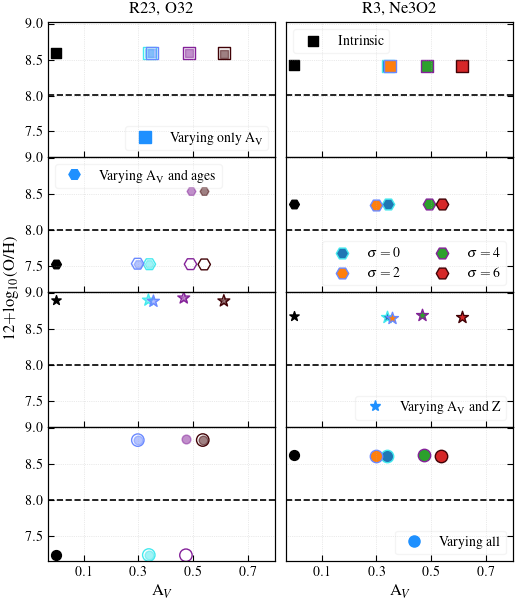

In [ ]:
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize=(6, 7), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs = axs.ravel()
twinaxs = [ax.twinx() for ax in axs]

markers = ['s', 'H', '*', 'o']
custom = [Line2D([], [], marker=ii, markersize=8, color='dodgerblue', linestyle='None') for ii in markers]

for ii in range(4):
    axs[2*ii].axhline(y=logOH[ii], label='Mass-weighted', color='black', ls='dashed')
    axs[2*ii+1].axhline(y=logOH[ii], color='black', ls='dashed')


# Varying only Av
axs[0].scatter(0.0, compute_metallicity_dust_correction(line_gals_int[0], Balmerdust=False)[0], color='black', s=50, marker=markers[0])
axs[1].scatter(0.0, compute_metallicity_nodust_correction(line_gals_int[0])[0], color='black', s=50, marker=markers[0], label=r'Intrinsic')

# Varying Av and ages
axs[2].scatter(0.0, compute_metallicity_dust_correction(line_gals_int[1], Balmerdust=False)[0], color='black', s=50, marker=markers[1])
axs[3].scatter(0.0, compute_metallicity_nodust_correction(line_gals_int[1])[0], color='black', s=50, marker=markers[1])

# Varying Av and Z
axs[4].scatter(0.0, compute_metallicity_dust_correction(line_gals_int[2], Balmerdust=False)[0], color='black', s=50, marker=markers[2])
axs[5].scatter(0.0, compute_metallicity_nodust_correction(line_gals_int[2])[0], color='black', s=50, marker=markers[2])


# Varying all
axs[6].scatter(0.0, compute_metallicity_dust_correction(line_gals_int[3], Balmerdust=False)[0], color='black', s=50, marker=markers[3])
axs[7].scatter(0.0, compute_metallicity_nodust_correction(line_gals_int[3])[0], color='black', s=50, marker=markers[3])


for jj in range(4):

    for ii in range(num_gals):

        axs[2*jj].scatter(Av[jj][ii], compute_metallicity_dust_correction(line_gals_att[jj][ii])[0], edgecolor=colors[ii], facecolor='None', s=80, marker=markers[jj])
        
        axs[2*jj].scatter(Av[jj][ii], compute_metallicity_dust_correction(line_gals_att[jj][ii], Balmerdust=False, Avdust=True, Av=Av[jj][ii])[0], color=colors[ii], s=40, marker=markers[jj], alpha=0.5)   

        if jj==1:
            axs[2*jj+1].scatter(Av[jj][ii], compute_metallicity_nodust_correction(line_gals_att[jj][ii])[0], edgecolor=colors[ii], s=80, marker=markers[jj], label=rF'$\sigma={nsigma[ii]}$')
        else:
            axs[2*jj+1].scatter(Av[jj][ii], compute_metallicity_nodust_correction(line_gals_att[jj][ii])[0], edgecolor=colors[ii], s=80, marker=markers[jj])

for ii in [1,3,5,7]:    
    axs[ii].yaxis.tick_right()

for ax in axs:
    ax.grid(ls='dotted', alpha=0.5)
    ax.set_xticks(np.arange(0.1,1,0.2))
    ax.set_xlim(-0.03,0.8)

for ax in twinaxs:
    ax.set_xlim(-0.03,0.8)
    ax.set_yticks([])
    ax.set_yticklabels([])

axs[-1].set_xlabel(r'A$_{V}$', fontsize=12)
axs[-2].set_xlabel(r'A$_{V}$', fontsize=12)   

axs[0].set_title('R23, O32', fontsize=12)
axs[1].set_title('R3, Ne3O2', fontsize=12)

twinaxs[0].legend([custom[0]], [r'Varying only A$_{\mathrm{V}}$'], loc='lower right', framealpha=0.2)
axs[1].legend(frameon=True, loc='upper left', framealpha=0.2)

twinaxs[2].legend([custom[1]], ['Varying A$_{\mathrm{V}}$ and ages'], loc='upper left', framealpha=0.2)
axs[3].legend(frameon=True, loc='lower right', ncols=2, framealpha=0.2)

twinaxs[5].legend([custom[2]], ['Varying A$_{\mathrm{V}}$ and Z'], loc='lower right', framealpha=0.2)

twinaxs[7].legend([custom[3]], ['Varying all'], loc='lower right', framealpha=0.2)

fig.text(0.05, 0.5, r'$12+$log$_{10}$(O/H)', va='center', fontsize=12, rotation='vertical')

fig.subplots_adjust(hspace=0,wspace=0.05)

plt.savefig('app_plots/toy_met_Av_sanders.png', dpi=300)
plt.show()   

In [ ]:
def flares_galaxies(ii, func, data):
    """Function to package FLARES line luminosities into dictionaries.
    
    Args:
        ii (int): The index of the galaxy to load.
        func (function): The function to apply to the line luminosities.
        data (tuple): A tuple containing the line luminosities and other properties of the galaxies.
        
    Returns:
        The output of the function applied to the line luminosities and other properties of the galaxy, here the strong-line metallicity with different dust corrections applied.
    """
    
    Halpha, Hbeta, OII3727, OIII4959, OIII5007, NeIII3869, Av, HbetaEW = data
    
    gal = {}
    gal['Av'] = Av[ii]
    gal['HbetaEW'] = HbetaEW
    gal['Halpha'] = Halpha[ii]
    gal['Hbeta'] = Hbeta[ii]
    gal['[OII]3727,29'] = OII3727[ii]
    gal['[OIII]4959'] = OIII4959[ii]
    gal['[OIII]5007'] = OIII5007[ii]
    gal[ 'NeIII3869'] = NeIII3869[ii]
    
    gal['R23'] = (gal['[OIII]4959']+gal['[OIII]5007']+gal['[OII]3727,29'])/gal['Hbeta']
    gal['R3'] = gal['[OIII]5007']/gal["Hbeta"]
    gal['R2'] = gal['[OII]3727,29']/gal["Hbeta"]
    gal['Ne3O2'] = gal['NeIII3869']/gal['[OII]3727,29']
    gal['O32'] = gal['[OIII]5007']/gal['[OII]3727,29']
    
    out = func(gal)
    
    return out

def get_flares_galZ(data_att, data_int, tot_gals):   
    """Helper functions to get the FLARES strong-line metallicities.
    
    Args:
        data_att (tuple): A tuple containing the line luminosities and other properties of the galaxies
        data_int (tuple): A tuple containing the line luminosities and other properties of the galaxies without dust correction
        tot_gals (int): The total number of galaxies to process
    
    Returns:
        tuple: A tuple containing the following arrays with OIII5007 flux greater than the specified limit and stellar mass greater than the specified limit:
            - flares_dust_corr_Z: The strong-line metallicity of the galaxies with dust correction applied.
            - flares_Avdust_corr_Z: The strong-line metallicity of the galaxies with only Av dust correction applied.
            - flares_int_dust_corr_Z: The strong-line metallicity of the galaxies without any dust correction applied.
    """
    
    f = partial(compute_metallicity_dust_correction, Avdust=False, Balmerdust=True)
    flares_dust_corr_Z = np.array([flares_galaxies(ii, compute_metallicity_dust_correction, data_att) for ii in range(tot_gals)])[:,0]
    
    f = partial(compute_metallicity_dust_correction, Avdust=True, Balmerdust=False)
    flares_Avdust_corr_Z = np.array([flares_galaxies(ii, f, data_att) for ii in range(tot_gals)])[:,0]
    
    flares_nodust_corr_Z = np.array([flares_galaxies(ii, compute_metallicity_nodust_correction, data_att) for ii in range(tot_gals)])[:,0]

    flares_int_nodust_corr_Z = np.array([flares_galaxies(ii, compute_metallicity_nodust_correction, data_int) for ii in range(tot_gals)])[:,0]
    
    f = partial(compute_metallicity_dust_correction, Balmerdust=False)
    flares_int_dust_corr_Z = np.array([flares_galaxies(ii, f, data_int) for ii in range(tot_gals)])[:,0]
    
    return np.asarray(flares_dust_corr_Z, dtype=np.float32), np.asarray(flares_Avdust_corr_Z, dtype=np.float32), np.asarray(flares_nodust_corr_Z, dtype=np.float32), np.asarray(flares_int_dust_corr_Z, dtype=np.float32), np.asarray(flares_int_nodust_corr_Z, dtype=np.float32)

#### Calculate strong-line calibration derived metallicities for FLARES

In [8]:
tags = ['010_z005p000', '009_z006p000', '008_z007p000', '007_z008p000', '006_z009p000', '005_z010p000']

df = pd.read_csv('./data/weights_grid.txt')
weights = np.array(df['weights'])

quantiles = [0.01,0.16,0.50,0.84,0.99]
OIIIlimit=3e-18*erg/s/cm**2

mbins = np.arange(8,11.5,0.3)
mbincen = (mbins[1:] + mbins[:-1])/2.

lbins = -np.arange(17., 24.5, 0.5)[::-1]
lbincen = (lbins[1:] + lbins[:-1])/2.

data_lines = {}
data_mass = {}
data_luv = {}
met_data = {}

for ii, tag in enumerate(tags):

    z = float(tag[5:].replace('p','.'))

    func    = partial(get_data, tag=tag, OIIIlimit=OIIIlimit, cosmo=cosmo)
    pool    = MultiPool(processes=8)
    dat     = np.array(list(pool.map(func, np.arange(0,40))), dtype='object')
    pool.close()


    Mstar = np.log10(np.concatenate(dat[:,0]))
    MFUVatt = np.concatenate(dat[:,1])
    Halpha = np.concatenate(dat[:,2])
    OIII5007 = np.concatenate(dat[:,3])
    OIII4959 = np.concatenate(dat[:,4])
    OII3727 = np.concatenate(dat[:,5])
    NeIII3869 = np.concatenate(dat[:,6])
    OIII5007int = np.concatenate(dat[:,7])
    OIII4959int = np.concatenate(dat[:,8])
    OII3727int = np.concatenate(dat[:,9])
    NeIII3869int = np.concatenate(dat[:,10])
    Hbeta = np.concatenate(dat[:,11])
    Halphaint = np.concatenate(dat[:,12])
    Hbetaint = np.concatenate(dat[:,13])
    MassweightedZ = 8.69 + np.log10(np.concatenate(dat[:,14])/Zsun)
    Av = np.concatenate(dat[:,15])
    HbetaEW = np.concatenate(dat[:,16])

    tot_gals = len(Mstar)

    data_att = (Halpha, Hbeta, OII3727, OIII4959, OIII5007, NeIII3869, Av, HbetaEW)
    data_int = (Halphaint, Hbetaint, OII3727int, OIII4959int, OIII5007int, NeIII3869int, Av, HbetaEW)
    
    data_lines[F'R23_z{z}'] = (OIII5007+OIII4959+OII3727)/Hbeta
    data_lines[F'R3_z{z}'] = OIII5007/Hbeta
    data_lines[F'O32_z{z}'] = OIII5007/OII3727
    data_lines[F'Ne3O2_z{z}'] = NeIII3869/OII3727
    
    data_lines[F'intR23_z{z}'] = (OIII5007int+OIII4959int+OII3727int)/Hbetaint
    data_lines[F'intR3_z{z}'] = OIII5007int/Hbetaint
    data_lines[F'intO32_z{z}'] = OIII5007int/OII3727int
    data_lines[F'intNe3O2_z{z}'] = NeIII3869int/OII3727int

    flares_dust_corr_Z, flares_Avdust_corr_Z, flares_nodust_corr_Z, flares_int_dust_corr_Z, flares_int_nodust_corr_Z = get_flares_galZ(data_att, data_int, tot_gals)
    

    met_data[F'dustcorr_z{z}'] = flares_dust_corr_Z
    met_data[F'Avdustcorr_z{z}'] = flares_Avdust_corr_Z
    met_data[F'nodustcorr_z{z}'] = flares_nodust_corr_Z
    met_data[F'intdustcorr_z{z}'] = flares_int_dust_corr_Z
    met_data[F'intnodustcorr_z{z}'] = flares_int_nodust_corr_Z
    met_data[F'mstar_z{z}'] = Mstar

    ws = np.zeros(tot_gals)
    n = 0
    for jj in range(40):
        if jj==0:
            ws[0:len(dat[jj][0])] = weights[jj]
        else:
            ws[n:n+len(dat[jj][0])] = weights[jj]

        n+=len(dat[jj][0])
    
    # Mass bins    
    hist, edges = np.histogram(Mstar, mbins)
    data_mass[F'N_z{z}'] = hist
    
    tmp = binned_weighted_quantile(Mstar, MassweightedZ, ws, mbins, quantiles)
    data_mass[F'massweighted_z{z}'] = tmp.T    
    
    tmp = binned_weighted_quantile(Mstar, flares_int_dust_corr_Z, ws, mbins, quantiles)
    data_mass[F'intdustcorr_z{z}'] = tmp.T
    tmp = binned_weighted_quantile(Mstar, flares_dust_corr_Z, ws, mbins, quantiles)
    data_mass[F'dustcorr_z{z}'] = tmp.T
    tmp = binned_weighted_quantile(Mstar, flares_Avdust_corr_Z, ws, mbins, quantiles)
    data_mass[F'avdustcorr_z{z}'] = tmp.T
    
    tmp = binned_weighted_quantile(Mstar, flares_int_nodust_corr_Z, ws, mbins, quantiles)
    data_mass[F'intnodustcorr_z{z}'] = tmp.T
    tmp = binned_weighted_quantile(Mstar, flares_nodust_corr_Z, ws, mbins, quantiles)
    data_mass[F'nodustcorr_z{z}'] = tmp.T
    
    
    # FUV bins
    hist, edges = np.histogram(MFUVatt, lbins)
    data_luv[F'N_z{z}'] = hist
    
    tmp = binned_weighted_quantile(MFUVatt, MassweightedZ, ws, lbins, quantiles)
    data_luv[F'massweighted_z{z}'] = tmp.T    
    
    tmp = binned_weighted_quantile(MFUVatt, flares_int_dust_corr_Z, ws, lbins, quantiles)
    data_luv[F'intdustcorr_z{z}'] = tmp.T
    tmp = binned_weighted_quantile(MFUVatt, flares_dust_corr_Z, ws, lbins, quantiles)
    data_luv[F'dustcorr_z{z}'] = tmp.T
    tmp = binned_weighted_quantile(MFUVatt, flares_Avdust_corr_Z, ws, lbins, quantiles)
    data_luv[F'avdustcorr_z{z}'] = tmp.T
    
    tmp = binned_weighted_quantile(MFUVatt, flares_int_nodust_corr_Z, ws, lbins, quantiles)
    data_luv[F'intnodustcorr_z{z}'] = tmp.T
    tmp = binned_weighted_quantile(MFUVatt, flares_nodust_corr_Z, ws, lbins, quantiles)
    data_luv[F'nodustcorr_z{z}'] = tmp.T

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/1069130549.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/1069130549.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  MassweightedZ = np.array(hf[num+tag+'/Galaxy/Metallicity'].get('MassWeightedYoungStellarZ'), dtype = np.float32)
/var/folders/j_

#### Plot R23 vs O32 and R3 vs Ne3O2 for the FLARES galaxies

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/1069130549.py:66: UserWarning: The following kwargs were not used by contour: 'label'
  cs = ax.contour(Xgrid, Ygrid, z, levels=levels, cmap=cmap, label=label, zorder=zorder, alpha=alpha, origin='lower')


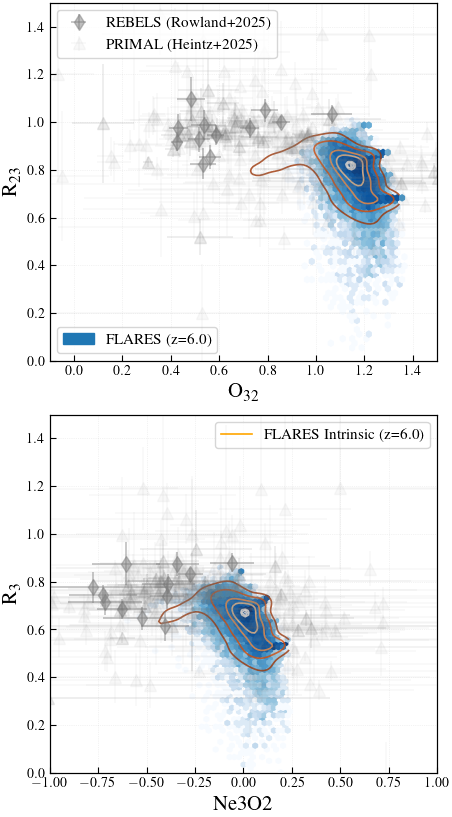

In [9]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(5, 10), sharex=False, sharey=False, facecolor='w', edgecolor='k')
axs = axs.ravel()
twinxaxs = np.array([ax.twinx() for ax in axs])
z=6.0


axs[0] = plot_hexbin(np.log10(data_lines[F'O32_z{z}']), np.log10(data_lines[F'R23_z{z}']), ax=axs[0], cmap='Blues', gridsize=(25,25), label=F'FLARES (z={z})', zorder=10)
axs[1] = plot_hexbin(np.log10(data_lines[F'Ne3O2_z{z}']), np.log10(data_lines[F'R3_z{z}']), ax=axs[1], cmap='Blues', gridsize=(35,30), label=F'FLARES (z={z})', zorder=10)


axs[0] = plot_contour(np.log10(data_lines[F'intO32_z{z}']), np.log10(data_lines[F'intR23_z{z}']), ax=axs[0], label=F'FLARES intrinsic (z={z})', cmap='Oranges_r', zorder=10, alpha=0.8)
axs[1] = plot_contour(np.log10(data_lines[F'intNe3O2_z{z}']), np.log10(data_lines[F'intR3_z{z}']), ax=axs[1], label=F'FLARES intrinsic (z={z})', cmap='Oranges_r', zorder=10, alpha=0.8)



obs_OIIIr = unumpy.uarray(plot_rebels_data('[OIII]5007_flux'), plot_rebels_data('[OIII]5007_flux_error'))
obs_OIIIb = unumpy.uarray(plot_rebels_data('[OIII]4959_flux'), plot_rebels_data('[OIII]4959_flux_error'))
obs_OII = unumpy.uarray(plot_rebels_data('[OII]3727,29_flux'), plot_rebels_data('[OII]3727,29_flux_error'))
obs_NeIII = unumpy.uarray(plot_rebels_data('[NeIII]3869+HeI+Hz_flux'), plot_rebels_data('[NeIII]3869+HeI+Hz_flux_error'))
obs_Hb = unumpy.uarray(plot_rebels_data('H-beta_flux'), plot_rebels_data('H-beta_flux_error'))

obs_x0 = unumpy.log10(obs_OIIIr/obs_OII)
obs_y0 = unumpy.log10((obs_OIIIr + obs_OIIIb + obs_OII)/obs_Hb)

obs_x1 = unumpy.log10(obs_NeIII/obs_OII)
obs_y1 = unumpy.log10(obs_OIIIr/obs_Hb)

twinxaxs[0].errorbar(unumpy.nominal_values(obs_x0), unumpy.nominal_values(obs_y0), xerr=unumpy.std_devs(obs_x0), yerr=unumpy.std_devs(obs_y0), label='REBELS (Rowland+2025)', color='grey', marker='d', ls='None', alpha=0.5, markersize=8, zorder=0)
twinxaxs[1].errorbar(unumpy.nominal_values(obs_x1), unumpy.nominal_values(obs_y1), xerr=unumpy.std_devs(obs_x1), yerr=unumpy.std_devs(obs_y1), label='REBELS (Rowland+2025)', color='grey', marker='d', ls='None', alpha=0.5, markersize=8, zorder=0)

df = pd.read_csv('./data/JWSTPRIMAL_All_red.csv', delimiter=';')
df = df.dropna()

req_columnns = ['OIII_5008', 'OIII_4960', 'OII_3727', 'Hbeta', 'NeIII_3870']
df = df[(df[req_columnns] >= 0).all(axis=1)]

obs_OIIIr = unumpy.uarray(df['OIII_5008'], df['err_OIII_5008'])
obs_OIIIb = unumpy.uarray(df['OIII_4960'], df['err_OIII_4960'])
obs_OII = unumpy.uarray(df['OII_3727'], df['err_OII_3727'])
obs_Hb = unumpy.uarray(df['Hbeta'], df['err_Hbeta'])
obs_NeIII = unumpy.uarray(df['NeIII_3870'], df['err_NeIII_3870'])

obs_x0 = unumpy.log10(obs_OIIIr/obs_OII)
obs_y0 = unumpy.log10((obs_OIIIr + obs_OIIIb + obs_OII)/obs_Hb)

obs_x1 = unumpy.log10(obs_NeIII/obs_OII)
obs_y1 = unumpy.log10(obs_OIIIr/obs_Hb)

ok = (unumpy.std_devs(obs_x0)<2) * (unumpy.std_devs(obs_y0)<2) * (unumpy.std_devs(obs_x1)<2) * (unumpy.std_devs(obs_y1)<2) 
obs_x0 = obs_x0[ok]
obs_y0 = obs_y0[ok]
obs_x1 = obs_x1[ok]
obs_y1 = obs_y1[ok]
# ok = np.random.randint(0, len(obs_x), 60)
# obs_x = obs_x[ok]
# obs_y = obs_y[ok]

twinxaxs[0].errorbar(unumpy.nominal_values(obs_x0), unumpy.nominal_values(obs_y0), xerr=unumpy.std_devs(obs_x0), yerr=unumpy.std_devs(obs_y0), label='PRIMAL (Heintz+2025)', color='grey', marker='^', ls='None', alpha=0.05, markersize=8, zorder=0)
twinxaxs[1].errorbar(unumpy.nominal_values(obs_x1), unumpy.nominal_values(obs_y1), xerr=unumpy.std_devs(obs_x1), yerr=unumpy.std_devs(obs_y1), label='PRIMAL (Heintz+2025)', color='grey', marker='^', ls='None', alpha=0.05, markersize=8, zorder=0)



axs[0].set_xlabel(r'O$_{32}$', fontsize=15)
axs[0].set_ylabel(r'R$_{23}$', fontsize=15)

axs[1].set_xlabel(r'Ne3O2', fontsize=15)
axs[1].set_ylabel(r'R$_{3}$', fontsize=15)

xlim = [[-0.1,1.5], [-1,1]]
ylim = [[0,1.5], [0,1.5]]

for ii in range(2):
    axs[ii].set_xlim(xlim[ii])
    axs[ii].set_ylim(ylim[ii])
    axs[ii].grid(ls='dotted')
    twinxaxs[ii].set_xlim(xlim[ii])
    twinxaxs[ii].set_ylim(ylim[ii])
    twinxaxs[ii].set_yticks([])
    twinxaxs[ii].set_yticklabels([])

twinxaxs[0].legend(fontsize=11, loc='upper left') 
axs[0].legend(fontsize=11, loc='lower left') 
custom = [Line2D([], [], color='orange', linestyle='solid')]
axs[1].legend(custom, [F'FLARES Intrinsic (z={z})'], loc='upper right', fontsize=11) 

fig.subplots_adjust(hspace=0.15)

plt.savefig('app_plots/flares_R23-O32_R3-Ne3O2.png', dpi=300, bbox_inches='tight')   
plt.show()

#### 1-to-1 plot of intrinsic vs observed (dust atenuated) R23 and R3

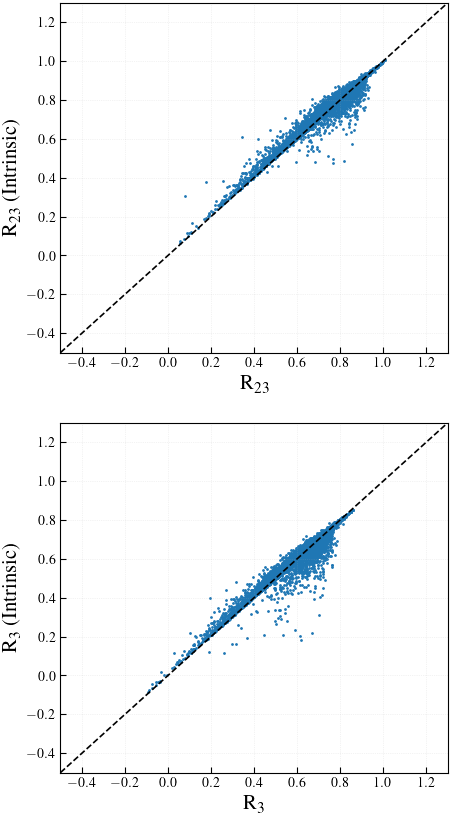

In [10]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(5, 10), sharex=False, sharey=False, facecolor='w', edgecolor='k')
axs = axs.ravel()
z=6.0

x = np.arange(-0.5,2,0.1)

axs[0].scatter(np.log10(data_lines[F'R23_z{z}']), np.log10(data_lines[F'intR23_z{z}']), s=1)
axs[1].scatter(np.log10(data_lines[F'R3_z{z}']), np.log10(data_lines[F'intR3_z{z}']), s=1)

axs[0].set_xlabel(r'R$_{23}$', fontsize=15)
axs[0].set_ylabel(r'R$_{23}$ (Intrinsic)', fontsize=15)

axs[1].set_xlabel(r'R$_{3}$', fontsize=15)
axs[1].set_ylabel(r'R$_{3}$ (Intrinsic)', fontsize=15)

for ax in axs:
    ax.grid(ls='dotted')
    ax.set_xlim(-0.5,1.3)
    ax.set_ylim(-0.5,1.3)
    ax.plot(x, x, ls='dashed', color='black')
    
plt.show()

#### MZR relation in FLARES using Sanders+2024

<>:99: SyntaxWarning: invalid escape sequence '\s'
<>:100: SyntaxWarning: invalid escape sequence '\s'
<>:102: SyntaxWarning: invalid escape sequence '\m'
<>:103: SyntaxWarning: invalid escape sequence '\m'
<>:99: SyntaxWarning: invalid escape sequence '\s'
<>:100: SyntaxWarning: invalid escape sequence '\s'
<>:102: SyntaxWarning: invalid escape sequence '\m'
<>:103: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/3220752876.py:99: SyntaxWarning: invalid escape sequence '\s'
  axs[0].set_xlabel('log$_{10}$(M$_{\star}$/M$_{\odot}$)', fontsize=14)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/3220752876.py:100: SyntaxWarning: invalid escape sequence '\s'
  axs[1].set_xlabel('log$_{10}$(M$_{\star}$/M$_{\odot}$)', fontsize=14)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/3220752876.py:102: SyntaxWarning: invalid escape sequence '\m'
  axs[2].set_xlabel('M$_{\mathrm{FUV}}$', fontsize=14)
/var

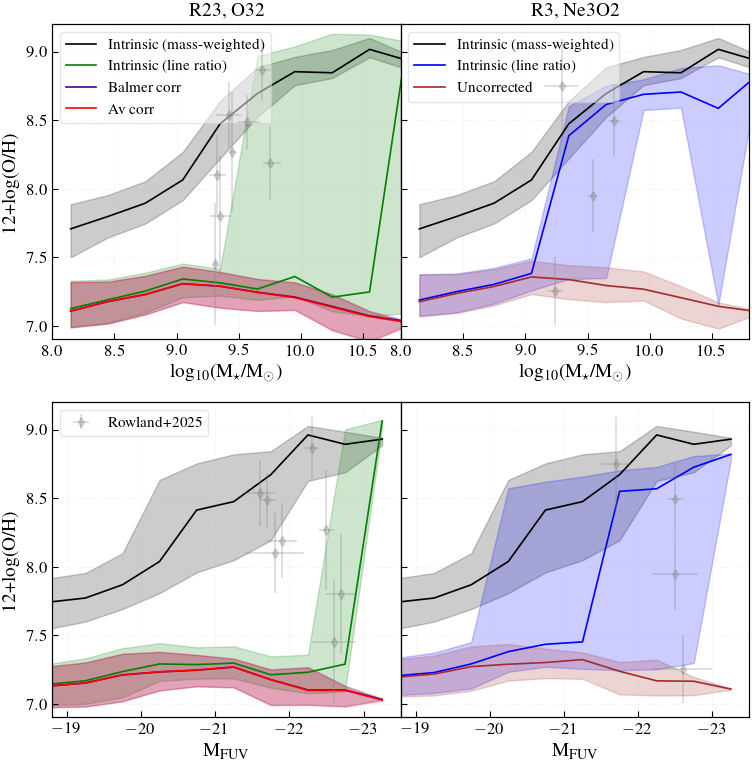

In [11]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(9, 9), sharex=False, sharey=True, facecolor='w', edgecolor='k')
axs=axs.ravel()
twinaxs = np.array([ax.twinx() for ax in axs])

labels1 = ['Intrinsic (mass-weighted)', 'Intrinsic (line ratio)', 'Balmer corr', 'Av corr']
labels2 = ['Intrinsic (mass-weighted)', 'Intrinsic (line ratio)', 'Uncorrected']

colors1 = ['black', 'green', 'indigo', 'red']
colors2 = ['black', 'blue', 'brown']

# z = 7
tag = tags[1]
z = float(tag[5:].replace('p','.'))

# Mass bins: R23-O32
ok = np.where(data_mass[F'N_z{z}']>5)[0]

axs[0].plot(mbincen[ok], data_mass[F'massweighted_z{z}'][2][ok], color=colors1[0], label=labels1[0])
axs[0].fill_between(mbincen[ok], data_mass[F'massweighted_z{z}'][1][ok], data_mass[F'massweighted_z{z}'][3][ok], color=colors1[0], alpha=0.2)

axs[0].plot(mbincen[ok], data_mass[F'intdustcorr_z{z}'][2][ok], color=colors1[1], label=labels1[1])
axs[0].fill_between(mbincen[ok], data_mass[F'intdustcorr_z{z}'][1][ok], data_mass[F'intdustcorr_z{z}'][3][ok], color=colors1[1], alpha=0.2)

axs[0].plot(mbincen[ok], data_mass[F'dustcorr_z{z}'][2][ok], color=colors1[2], label=labels1[2])
axs[0].fill_between(mbincen[ok], data_mass[F'dustcorr_z{z}'][1][ok], data_mass[F'dustcorr_z{z}'][3][ok], color=colors1[2], alpha=0.2)

axs[0].plot(mbincen[ok], data_mass[F'avdustcorr_z{z}'][2][ok], color=colors1[3], label=labels1[3])
axs[0].fill_between(mbincen[ok], data_mass[F'avdustcorr_z{z}'][1][ok], data_mass[F'avdustcorr_z{z}'][3][ok], color=colors1[3], alpha=0.2)


# #Mass bins: R3-Ne3O2
axs[1].plot(mbincen[ok], data_mass[F'massweighted_z{z}'][2][ok], color=colors2[0], label=labels2[0])
axs[1].fill_between(mbincen[ok], data_mass[F'massweighted_z{z}'][1][ok], data_mass[F'massweighted_z{z}'][3][ok], color=colors2[0], alpha=0.2)

axs[1].plot(mbincen[ok], data_mass[F'intnodustcorr_z{z}'][2][ok], color=colors2[1], label=labels2[1])
axs[1].fill_between(mbincen[ok], data_mass[F'intnodustcorr_z{z}'][1][ok], data_mass[F'intnodustcorr_z{z}'][3][ok], color=colors2[1], alpha=0.2)

axs[1].plot(mbincen[ok], data_mass[F'nodustcorr_z{z}'][2][ok], color=colors2[2], label=labels2[2])
axs[1].fill_between(mbincen[ok], data_mass[F'nodustcorr_z{z}'][1][ok], data_mass[F'nodustcorr_z{z}'][3][ok], color=colors2[2], alpha=0.2)


# Luminosity bins: R23-O32
ok = np.where(data_luv[F'N_z{z}']>5)[0]

axs[2].plot(lbincen[ok], data_luv[F'massweighted_z{z}'][2][ok], color=colors1[0])
axs[2].fill_between(lbincen[ok], data_luv[F'massweighted_z{z}'][1][ok], data_luv[F'massweighted_z{z}'][3][ok], color=colors1[0], alpha=0.2)

axs[2].plot(lbincen[ok], data_luv[F'intdustcorr_z{z}'][2][ok], color=colors1[1])
axs[2].fill_between(lbincen[ok], data_luv[F'intdustcorr_z{z}'][1][ok], data_luv[F'intdustcorr_z{z}'][3][ok], color=colors1[1], alpha=0.2)

axs[2].plot(lbincen[ok], data_luv[F'dustcorr_z{z}'][2][ok], color=colors1[2])
axs[2].fill_between(lbincen[ok], data_luv[F'dustcorr_z{z}'][1][ok], data_luv[F'dustcorr_z{z}'][3][ok], color=colors1[2], alpha=0.2)

axs[2].plot(lbincen[ok], data_luv[F'avdustcorr_z{z}'][2][ok], color=colors1[3])
axs[2].fill_between(lbincen[ok], data_luv[F'avdustcorr_z{z}'][1][ok], data_luv[F'avdustcorr_z{z}'][3][ok], color=colors1[3], alpha=0.2)


#Luminosity bins: R3-Ne3O2
axs[3].plot(lbincen[ok], data_luv[F'massweighted_z{z}'][2][ok], color=colors2[0])
axs[3].fill_between(lbincen[ok], data_luv[F'massweighted_z{z}'][1][ok], data_luv[F'massweighted_z{z}'][3][ok], color=colors2[0], alpha=0.2)

axs[3].plot(lbincen[ok], data_luv[F'intnodustcorr_z{z}'][2][ok], color=colors2[1])
axs[3].fill_between(lbincen[ok], data_luv[F'intnodustcorr_z{z}'][1][ok], data_luv[F'intnodustcorr_z{z}'][3][ok], color=colors2[1], alpha=0.2)

axs[3].plot(lbincen[ok], data_luv[F'nodustcorr_z{z}'][2][ok], color=colors2[2])
axs[3].fill_between(lbincen[ok], data_luv[F'nodustcorr_z{z}'][1][ok], data_luv[F'nodustcorr_z{z}'][3][ok], color=colors2[2], alpha=0.2)

plot_met_data('rebels', twinaxs[0], ratio='R23')
plot_met_data('rebels', twinaxs[1], ratio='R3')

plot_met_data('rebels', twinaxs[2], xaxis='muv', ratio='R23')
plot_met_data('rebels', twinaxs[3], xaxis='muv', ratio='R3')




for jj in range(2):  
    
    axs[jj].set_xlim(8, 10.8)
    axs[jj+2].set_xlim(-18.8, -23.5)
    axs[jj].legend(fontsize=11, frameon=True, framealpha=0.5, loc='upper left')

    
for jj in range(4):
    axs[jj].grid(ls='dashed')
    twinaxs[jj].set_yticks([])
    twinaxs[jj].set_yticklabels([])    
    axs[jj].grid(ls='dotted')    
    axs[jj].set_ylim(6.9, 9.2)
    for label in (axs[jj].get_xticklabels() + axs[jj].get_yticklabels()):
        label.set_fontsize(12)


twinaxs[2].legend(loc='upper left', fontsize=11, frameon=True, framealpha=0.5)
    
axs[0].set_ylabel('12+log(O/H)', fontsize=14)  
axs[2].set_ylabel('12+log(O/H)', fontsize=14)  
    
axs[0].set_xlabel('log$_{10}$(M$_{\star}$/M$_{\odot}$)', fontsize=14)
axs[1].set_xlabel('log$_{10}$(M$_{\star}$/M$_{\odot}$)', fontsize=14)

axs[2].set_xlabel('M$_{\mathrm{FUV}}$', fontsize=14)
axs[3].set_xlabel('M$_{\mathrm{FUV}}$', fontsize=14)

axs[0].set_title('R23, O32', fontsize=14)
axs[1].set_title('R3, Ne3O2', fontsize=14)
    
fig.subplots_adjust(hspace=0.2,wspace=0)
plt.savefig(F'app_plots/line_ratio_mzr_lzr_z{int(z)}_sanders.png', dpi=300, bbox_inches='tight')

#### Redshift evolution of the MZR

<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/1633063603.py:47: SyntaxWarning: invalid escape sequence '\s'
  axs[2].set_xlabel('log$_{10}$(M$_{\star}$/M$_{\odot}$)', fontsize=12)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/1633063603.py:48: SyntaxWarning: invalid escape sequence '\s'
  axs[3].set_xlabel('log$_{10}$(M$_{\star}$/M$_{\odot}$)', fontsize=12)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start 

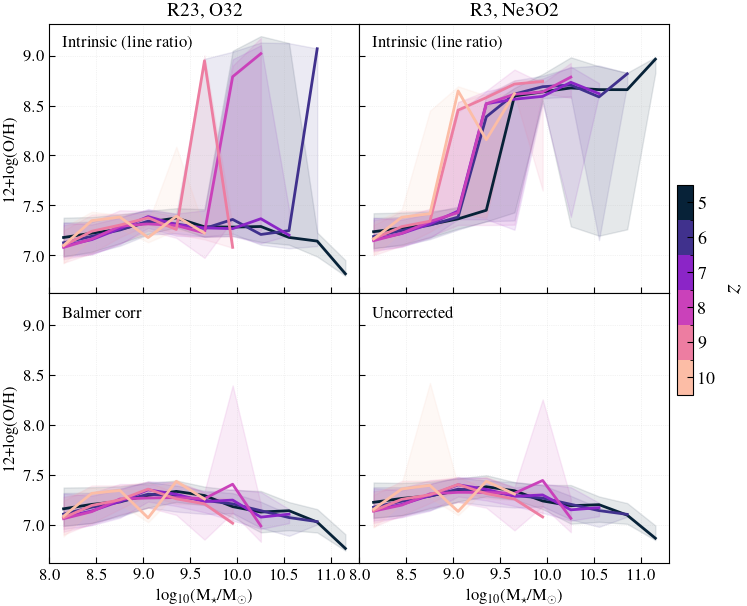

In [14]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(8, 7), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs=axs.ravel()

labels1 = ['Intrinsic (line ratio)', 'Balmer corr']
labels2 = ['Intrinsic (line ratio)', 'Uncorrected']

c_m =plt.get_cmap('cmr.bubblegum')
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,6,1), c_m.N)
# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

for ii, tag in enumerate(tags):
    
    z = float(tag[5:].replace('p','.'))
    
    ok = np.where(data_mass[F'N_z{z}']>5)[0]
    
    axs[0].plot(mbincen[ok], data_mass[F'intdustcorr_z{z}'][2][ok], color=s_m.to_rgba(ii), lw=2, zorder=10)
    axs[0].fill_between(mbincen[ok], data_mass[F'intdustcorr_z{z}'][1][ok], data_mass[F'intdustcorr_z{z}'][3][ok], color=s_m.to_rgba(ii), alpha=0.1, zorder=1)
    
    axs[1].plot(mbincen[ok], data_mass[F'intnodustcorr_z{z}'][2][ok], color=s_m.to_rgba(ii), lw=2, zorder=10)
    axs[1].fill_between(mbincen[ok], data_mass[F'intnodustcorr_z{z}'][1][ok], data_mass[F'intnodustcorr_z{z}'][3][ok], color=s_m.to_rgba(ii), alpha=0.1, zorder=1)
    
    axs[2].plot(mbincen[ok], data_mass[F'dustcorr_z{z}'][2][ok], color=s_m.to_rgba(ii), lw=2, zorder=10)
    axs[2].fill_between(mbincen[ok], data_mass[F'dustcorr_z{z}'][1][ok], data_mass[F'dustcorr_z{z}'][3][ok], color=s_m.to_rgba(ii), alpha=0.1, zorder=1)
    
    axs[3].plot(mbincen[ok], data_mass[F'nodustcorr_z{z}'][2][ok], color=s_m.to_rgba(ii), lw=2, zorder=10)
    axs[3].fill_between(mbincen[ok], data_mass[F'nodustcorr_z{z}'][1][ok], data_mass[F'nodustcorr_z{z}'][3][ok], color=s_m.to_rgba(ii), alpha=0.1, zorder=1)
    
for ii in range(2):
    axs[2*ii].legend(title=labels1[ii], frameon=False, title_fontsize=12, loc='upper left')
    axs[2*ii+1].legend(title=labels2[ii], frameon=False, title_fontsize=12, loc='upper left')

for jj in range(4):
    axs[jj].grid(ls='dotted')    
    # axs[jj].set_ylim(7.4, 8.5)
    for label in (axs[jj].get_xticklabels() + axs[jj].get_yticklabels()):
        label.set_fontsize(12)
    
axs[0].set_title('R23, O32', fontsize=14)
axs[1].set_title('R3, Ne3O2', fontsize=14)

axs[0].set_ylabel('12+log(O/H)', fontsize=12)  
axs[2].set_ylabel('12+log(O/H)', fontsize=12)  

axs[2].set_xlabel('log$_{10}$(M$_{\star}$/M$_{\odot}$)', fontsize=12)
axs[3].set_xlabel('log$_{10}$(M$_{\star}$/M$_{\odot}$)', fontsize=12)    

cbaxes = fig.add_axes([0.91, 0.35, 0.02, 0.3])
cbar = fig.colorbar(s_m, cax=cbaxes)
cbar.set_label(r'$z$', fontsize = 18)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(np.arange(5,11))
cbaxes.invert_yaxis()
for label in cbaxes.get_yticklabels():
    label.set_fontsize(13)

fig.subplots_adjust(hspace=0,wspace=0)    
plt.savefig(F'app_plots/line_ratio_mzr_z_evo_sanders.png', dpi=300, bbox_inches='tight')

#### Redshift evolution of the LZR

<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/244141695.py:48: SyntaxWarning: invalid escape sequence '\m'
  axs[2].set_xlabel('M$_{\mathrm{FUV}}$', fontsize=12)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_77040/244141695.py:49: SyntaxWarning: invalid escape sequence '\m'
  axs[3].set_xlabel('M$_{\mathrm{FUV}}$', fontsize=12)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when 

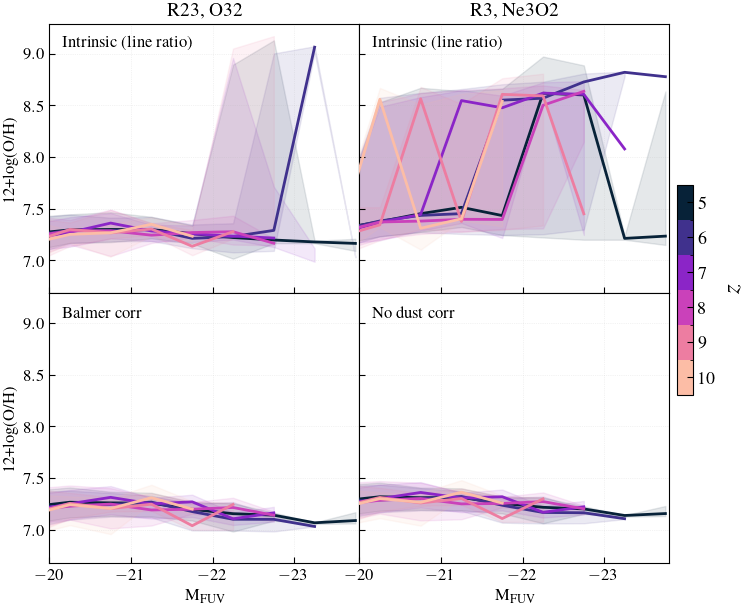

In [13]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(8, 7), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs=axs.ravel()

labels1 = ['Intrinsic (line ratio)', 'Balmer corr']
labels2 = ['Intrinsic (line ratio)', 'No dust corr']

c_m =plt.get_cmap('cmr.bubblegum')
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,6,1), c_m.N)
# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

for ii, tag in enumerate(tags):
    
    z = float(tag[5:].replace('p','.'))
    
    ok = np.where(data_luv[F'N_z{z}']>5)[0]
    
    axs[0].plot(lbincen[ok], data_luv[F'intdustcorr_z{z}'][2][ok], color=s_m.to_rgba(ii), lw=2, zorder=10)
    axs[0].fill_between(lbincen, data_luv[F'intdustcorr_z{z}'][1], data_luv[F'intdustcorr_z{z}'][3], color=s_m.to_rgba(ii), alpha=0.1, zorder=1)
    
    axs[1].plot(lbincen, data_luv[F'intnodustcorr_z{z}'][2], color=s_m.to_rgba(ii), lw=2, zorder=10)
    axs[1].fill_between(lbincen[ok], data_luv[F'intnodustcorr_z{z}'][1][ok], data_luv[F'intnodustcorr_z{z}'][3][ok], color=s_m.to_rgba(ii), alpha=0.1, zorder=1)
    
    axs[2].plot(lbincen[ok], data_luv[F'dustcorr_z{z}'][2][ok], color=s_m.to_rgba(ii), lw=2, zorder=10)
    axs[2].fill_between(lbincen[ok], data_luv[F'dustcorr_z{z}'][1][ok], data_luv[F'dustcorr_z{z}'][3][ok], color=s_m.to_rgba(ii), alpha=0.1, zorder=1)
    
    axs[3].plot(lbincen[ok], data_luv[F'nodustcorr_z{z}'][2][ok], color=s_m.to_rgba(ii), lw=2, zorder=10)
    axs[3].fill_between(lbincen[ok], data_luv[F'nodustcorr_z{z}'][1][ok], data_luv[F'nodustcorr_z{z}'][3][ok], color=s_m.to_rgba(ii), alpha=0.1, zorder=1)
    
for ii in range(2):
    axs[2*ii].legend(title=labels1[ii], frameon=False, title_fontsize=12, loc='upper left')
    axs[2*ii+1].legend(title=labels2[ii], frameon=False, title_fontsize=12, loc='upper left')

for jj in range(4):
    axs[jj].grid(ls='dotted')    
    # axs[jj].set_ylim(7.5, 8.25)
    axs[jj].set_xlim(-20, -23.8)
    for label in (axs[jj].get_xticklabels() + axs[jj].get_yticklabels()):
        label.set_fontsize(12)
    
axs[0].set_title('R23, O32', fontsize=14)
axs[1].set_title('R3, Ne3O2', fontsize=14)

axs[0].set_ylabel('12+log(O/H)', fontsize=12)  
axs[2].set_ylabel('12+log(O/H)', fontsize=12)  
    
axs[2].set_xlabel('M$_{\mathrm{FUV}}$', fontsize=12)
axs[3].set_xlabel('M$_{\mathrm{FUV}}$', fontsize=12)

cbaxes = fig.add_axes([0.91, 0.35, 0.02, 0.3])
cbar = fig.colorbar(s_m, cax=cbaxes)
cbar.set_label(r'$z$', fontsize = 18)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(np.arange(5,11))
cbaxes.invert_yaxis()
for label in cbaxes.get_yticklabels():
    label.set_fontsize(13)

fig.subplots_adjust(hspace=0,wspace=0)    
plt.savefig(F'app_plots/line_ratio_lzr_z_evo_sanders.png', dpi=300, bbox_inches='tight')